# Course project


**Основное**
- Дедлайн - 10 июля 23:59
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

OSError: dlopen(/Users/a.rudnitskiy/opt/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/a.rudnitskiy/opt/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

## Read data

In [ ]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

In [7]:
data.head()

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     2375  26984851472    1  1004906         1         1.39       364   
1     2375  26984851472    1  1033142         1         0.82       364   
2     2375  26984851472    1  1036325         1         0.99       364   
3     2375  26984851472    1  1082185         1         1.21       364   
4     2375  26984851472    1  8160430         1         1.50       364   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0        -0.60        1631        1          0.0                0.0  
1         0.00        1631        1          0.0                0.0  
2        -0.30        1631        1          0.0                0.0  
3         0.00        1631        1          0.0                0.0  
4        -0.39        1631        1          0.0                0.0

# Set global const

In [8]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 50 

# Process features dataset

In [9]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [10]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [11]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [12]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [13]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [14]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [15]:
# выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [16]:
data_val_matcher.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
2104867     2070  40618492260  594  1019940         1         1.00       311   
2107468     2021  40618753059  594   840361         1         0.99       443   

         retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
2104867        -0.29          40       86          0.0                0.0  
2107468         0.00         101       86          0.0                0.0

# Prefilter items

In [17]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/data/home/quasar/projects_personal/GeekBrainsRecommendations/lessons/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [18]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# оставляем общих пользователей
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (784420, 13) Users: 1915 Items: 4999
val_matcher
Shape: (163261, 12) Users: 1915 Items: 27118
train_ranker
Shape: (163261, 12) Users: 1915 Items: 27118
val_ranker
Shape: (115989, 12) Users: 1915 Items: 24042


# Init/train recommender

In [19]:
recommender = MainRecommender(data_train_matcher)

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [20]:
# Берем тестового юзера 2375

In [21]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 5569230, 844179]

In [22]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [23]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 841220, 1078652, 1133312]

In [24]:
recommender.get_similar_users_recommendation(2375, N=5)

[935578, 1080867, 977559, 1133654, 8020166]

# Eval recall of matching

### Измеряем recall@k

Это будет в ДЗ: 

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [25]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

user_id                                             actual
0        1  [853529, 865456, 867607, 872137, 874905, 87524...
1        6  [1024306, 1102949, 6548453, 835394, 940804, 96...

In [26]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 8min 54s, sys: 12.6 s, total: 9min 7s
Wall time: 20.2 s


In [27]:
%%time
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 90 µs, sys: 2 µs, total: 92 µs
Wall time: 6.91 µs


### Пример оборачивания

In [28]:
# # сырой и простой пример как можно обернуть в функцию
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [29]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [30]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [31]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [32]:
TOPK_RECALL = 50

In [33]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.061684201353290766),
 ('als_rec', 0.04803586835257474),
 ('sim_item_rec', 0.03091464458112718)]

### Precision@5 of matching

In [34]:
TOPK_PRECISION = 5

In [35]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.18872062663185182),
 ('als_rec', 0.12438642297650032),
 ('sim_item_rec', 0.0636031331592694)]

# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [36]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [37]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [38]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [39]:
df_match_candidates.head(2)

user_id                                         candidates
0     2070  [1105426, 1097350, 879194, 948640, 928263, 944...
1     2021  [950935, 1119454, 835578, 863762, 1097398, 101...

In [40]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [41]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [42]:
df_match_candidates.head(4)

user_id  item_id
0     2070  1105426
0     2070  1097350
0     2070   879194
0     2070   948640

### Check warm start

In [43]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (95750, 2) Users: 1915 Items: 4437


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [91]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

df_ranker_train['target'].fillna(0, inplace= True)

In [92]:
df_ranker_train.target.value_counts()

0.0    88346
1.0    11053
Name: target, dtype: int64

In [93]:
df_ranker_train.head(2)

user_id  item_id  target
0     2070  1105426     0.0
1     2070  1097350     0.0

(!) На каждого юзера 50 item_id-кандидатов

In [94]:
df_ranker_train['target'].mean()

0.11119830179378062

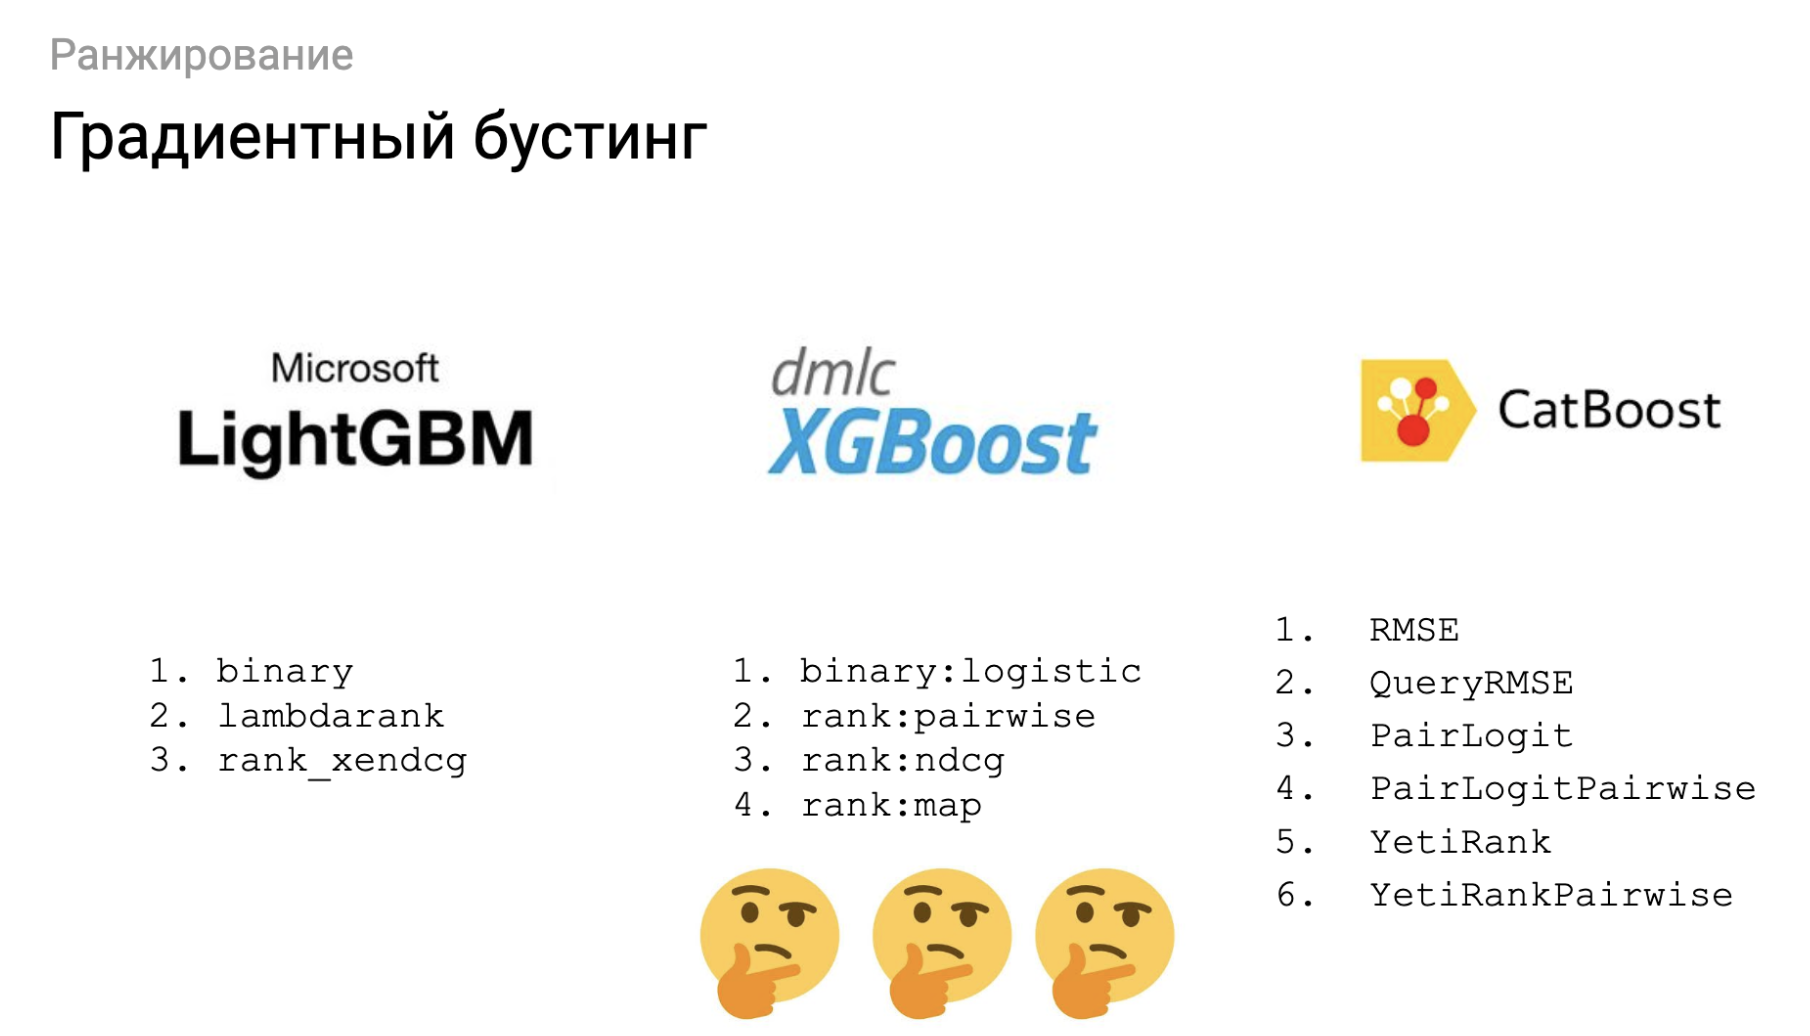

Слайд из [презентации](https://github.com/aprotopopov/retailhero_recommender/blob/master/slides/retailhero_recommender.pdf) решения 2-ого места X5 Retail Hero

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

## Подготавливаем фичи для обучения модели

### Описательные фичи

In [95]:
item_features.head(2)

item_id  manufacturer    department     brand            commodity_desc  \
0    25671             2       GROCERY  National                  FRZN ICE   
1    26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   

            sub_commodity_desc curr_size_of_product  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION

In [96]:
user_features.head(2)

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc  \
0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   

  household_size_desc kid_category_desc  user_id  
0                   2      None/Unknown        1  
1                   2      None/Unknown        7

In [97]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

user_id  item_id  target  manufacturer department     brand commodity_desc  \
0     2070  1105426     0.0            69       DELI   Private     SANDWICHES   
1     2070  1097350     0.0          2468    GROCERY  National  DOMESTIC WINE   

    sub_commodity_desc curr_size_of_product age_desc marital_status_code  \
0  SANDWICHES - (COLD)                         45-54                   U   
1     VALUE GLASS WINE                4 LTR    45-54                   U   

  income_desc homeowner_desc hh_comp_desc household_size_desc  \
0      50-74K        Unknown      Unknown                   1   
1      50-74K        Unknown      Unknown                   1   

  kid_category_desc  
0      None/Unknown  
1      None/Unknown

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_ranker

In [98]:
df_join_train_matcher.head()

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     2375  26984851472    1  1004906         1         1.39       364   
1     2375  26984851472    1  1033142         1         0.82       364   
2     2375  26984851472    1  1036325         1         0.99       364   
3     2375  26984851472    1  1082185         1         1.21       364   
4     2375  26984851472    1  8160430         1         1.50       364   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0        -0.60        1631        1          0.0                0.0  
1         0.00        1631        1          0.0                0.0  
2        -0.30        1631        1          0.0                0.0  
3         0.00        1631        1          0.0                0.0  
4        -0.39        1631        1          0.0                0.0

## !!! Пока выполните нотбук без этих строк, потом вернитесь и запустите их, обучите ранкер и посмотрите на метрики с ранжированием

In [99]:
# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)


# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

# df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


In [100]:
df_ranker_train.head()

user_id  item_id  target  manufacturer department     brand  \
0     2070  1105426     0.0            69       DELI   Private   
1     2070  1097350     0.0          2468    GROCERY  National   
2     2070   879194     0.0            69    DRUG GM   Private   
3     2070   948640     0.0          1213    DRUG GM  National   
4     2070   928263     0.0            69    DRUG GM   Private   

          commodity_desc   sub_commodity_desc curr_size_of_product age_desc  \
0             SANDWICHES  SANDWICHES - (COLD)                         45-54   
1          DOMESTIC WINE     VALUE GLASS WINE                4 LTR    45-54   
2  DIAPERS & DISPOSABLES         BABY DIAPERS                14 CT    45-54   
3  ORAL HYGIENE PRODUCTS    WHITENING SYSTEMS                 3 OZ    45-54   
4  DIAPERS & DISPOSABLES         BABY DIAPERS                13 CT    45-54   

  marital_status_code income_desc homeowner_desc hh_comp_desc  \
0                   U      50-74K        Unknown      Unknown   
1                   U      50-74K        Unknown      Unknown   
2                   U      50-74K        Unknown      Unknown   
3                   U      50-74K        Unknown      Unknown   
4                   U      50-74K        Unknown      Unknown   

  household_size_desc kid_category_desc  
0                   1      None/Unknown  
1                   1      None/Unknown  
2                   1      None/Unknown  
3                   1      None/Unknown  
4                   1      None/Unknown

In [101]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [102]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

## Обучение модели ранжирования

In [103]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=10,
                     n_estimators=500,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/home/quasar/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/quasar/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [104]:
df_ranker_predict = df_ranker_train.copy()

In [105]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [106]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

user_id                                             actual
0        1  [821867, 834484, 856942, 865456, 889248, 90795...
1        6  [920308, 926804, 946489, 1006718, 1017061, 107...

## Eval matching on test dataset

In [107]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 3.18 s, sys: 0 ns, total: 3.18 s
Wall time: 3.18 s


In [108]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1462140992167092)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [109]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [110]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [111]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.1462140992167092)
('reranked_own_rec', 0.1311749347258475)


In [ ]:
# смотрим на метрики выше и сравниваем что с ранжированием и без, добавляем фичи и то же смотрим

# Оценка на тесте для выполнения курсового проекта

In [235]:
df_test = pd.read_csv('../data/retail_test1.csv')
df_transactions = pd.read_csv('../data/transaction_data.csv')

In [31]:
df_test.head()

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     1340  41652823310  664   912987         1         8.49       446   
1      588  41652838477  664  1024426         1         6.29       388   
2     2070  41652857291  664   995242         5         9.10       311   
3     1602  41665647035  664   827939         1         7.99       334   
4     1602  41665647035  664   927712         1         0.59       334   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
0          0.0          52       96          0.0                0.0  
1          0.0           8       96          0.0                0.0  
2         -0.6          46       96          0.0                0.0  
3          0.0        1741       96          0.0                0.0  
4         -0.4        1741       96          0.0                0.0

In [32]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

user_id                                             actual
0        1  [880007, 883616, 931136, 938004, 940947, 94726...
1        6  [956902, 960791, 1037863, 1119051, 1137688, 84...

Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера